<h1 style="text-align:center;font-size:30px;" > Dog Breed Identification </h1>

## Problem Statement:


Build a Resnet50 CNN classifier to pridict scores of these breeds only: 
beagle, chihuahua, doberman, french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound, tibetan_mastiff.

github link: https://github.com/alankar23/dog_breed_identification

# **1**. Importing libraries :

In [107]:
import pandas as pd 
import numpy as np
from numpy import save
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from random import randrange
import kaggle
from prettytable import PrettyTable

## KERAS
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD
from keras import applications
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.activations import relu, softmax

# 2. Reading Data

In [ ]:
# Reading csv file with pandas
df = pd.read_csv('labels.csv')
df.shape

(10222, 2)

The dataset has total of 10222 rows


In [ ]:
# Creating custom dog breed list
dogs = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
images_dir = 'train/'
labels_dir = 'labels.csv'

In [ ]:
custom_breed = df.loc[df.breed.isin(dogs)].reset_index(drop=True)
custom_breed.shape

(841, 2)

After filtering custom breeds we get a dataset of approx 850 rows.


In [ ]:
custom_breed.head()

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


In [ ]:
custom_breed.breed.nunique()

10

In [ ]:
custom_breed['breed'].value_counts().sum

<bound method Series.sum of scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64>

The data has high number of images of scottish deerhound with 126 images, whereas golden retriver has lowest number of images with 64 only.


# 3. Displaying a random image of dog from the data. 


In [ ]:
random_dog = randrange(custom_breed.shape[0])
print(f'Random index location {random_dog}')

Random index location 288


Dog Breed: golden_retriever


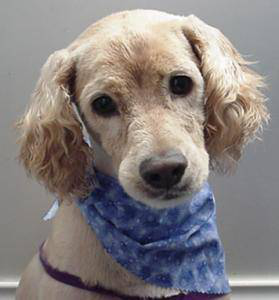

In [ ]:
print('Dog Breed:',custom_breed.loc[random_dog,'breed'])
Image.open(images_dir + custom_breed.loc[random_dog, "id"] + ".jpg")

# 4. Data preprocessing


In [ ]:
# Reading images and converting each image into array and apending them to a list
image_list = []
label_list = []

for index, x in tqdm(custom_breed.iterrows()):
    image = cv2.imread(images_dir + x['id'] + '.jpg')
    image = cv2.resize(image, (300, 300))
    image_list.append(image)
    label_list.append(x['breed'])

841it [00:02, 285.07it/s]


In [ ]:
print(f'No of Images: {len(image_list)} \nNo of Labels: {len(label_list)}')

No of Images: 841 
No of Labels: 841


In [ ]:
# Convert list to array
data = np.array(image_list) #/ 255
data.shape

(841, 300, 300, 3)

In [ ]:
# Saving the data and labes into npy file on the system [Optional]
save('dog_images.npy', data)
save('labels.npy', label_list)

In [181]:
# Reading the files:
from numpy import load
photos = load('dog_images.npy')
labels = load('labels.npy')
print(photos.shape, labels.shape)

(841, 300, 300, 3) (841,)


In [182]:
# Converting labels to numbers
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder()

vec = label_encoder.fit_transform(labels)

target = to_categorical(vec)
target

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(photos,target, test_size=0.3)

In [ ]:
# Checking the size of train and test data
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((588, 300, 300, 3), (253, 300, 300, 3), (588, 10), (253, 10))

In [ ]:
num_class = y_test.shape[1]

10

# 5.1 Building the Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
# Importing ResNet50 from Keras
from tensorflow.keras.applications.resnet50 import ResNet50
# load model
model = Sequential()

# Adding Resnet50 with pretrained imagenet weights
img_height,img_width = 300,300
model.add(ResNet50(weights="imagenet", pooling=max, include_top=False, input_shape= (img_height,img_width,3)))

# 2nd layer as Dense for classification
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))

# Not training firstlayer 
model.layers[0].trainable = False

In [ ]:
# Defining sgd optimizer


rate = 0.01
sgd = SGD(lr=rate)

In [ ]:
model.compile(optimizer= sgd,  loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Traing the network for 10 epochs
model.fit(x_train, y_train, epochs = 10,batch_size=32, validation_split=0.3)

Epoch 1/10
13/13 [==============================] - 6s 310ms/step - loss: 1.8475 - accuracy: 0.4077 - val_loss: 0.4477 - val_accuracy: 0.8870
Epoch 2/10
13/13 [==============================] - 3s 244ms/step - loss: 0.2128 - accuracy: 0.9593 - val_loss: 0.2301 - val_accuracy: 0.9322
Epoch 3/10
13/13 [==============================] - 3s 246ms/step - loss: 0.0964 - accuracy: 0.9707 - val_loss: 0.2193 - val_accuracy: 0.9435
Epoch 4/10
13/13 [==============================] - 3s 249ms/step - loss: 0.0425 - accuracy: 0.9899 - val_loss: 0.2109 - val_accuracy: 0.9266
Epoch 5/10
13/13 [==============================] - 3s 251ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9492
Epoch 6/10
13/13 [==============================] - 3s 253ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.1909 - val_accuracy: 0.9435
Epoch 7/10
13/13 [==============================] - 3s 255ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9322
Epoch 

In [141]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " , preds[0])
print ("Test Accuracy = ", preds[1])

8/8 [==============================] - 1s 157ms/step - loss: 0.1405 - accuracy: 0.9526
Loss =  0.1405491679906845
Test Accuracy =  0.9525691866874695


In [ ]:
y_pred_prob = model.predict(x_test)

In [ ]:
y_pred = y_pred_prob.argmax(axis=-1)
y_pred = to_categorical(y_pred)

# 5.2 Calculating Performace

In [109]:
# Calculating Performace metrics 
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [140]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,  average='micro')
recall = recall_score(y_test, y_pred,  average='micro')
f1 = f1_score(y_test, y_pred,  average='micro')
auc = roc_auc_score(y_test, y_pred,  average='micro')

In [136]:
from prettytable import PrettyTable

In [139]:
x = PrettyTable()
x.field_names = ["Metrics", "Score"]
x.add_row(["Accuracy", round(accuracy,3)])
x.add_row(["Precision", round(precision,3)])
x.add_row(["Recall", round(recall,3)])
x.add_row(["F1 Score", round(f1,3)])
x.add_row(["ROC-AUC Score", round(auc,3)])
print(x)

+---------------+-------+
|    Metrics    | Score |
+---------------+-------+
|    Accuracy   | 0.953 |
|   Precision   | 0.953 |
|     Recall    | 0.953 |
|    F1 Score   | 0.953 |
| ROC-AUC Score | 0.974 |
+---------------+-------+


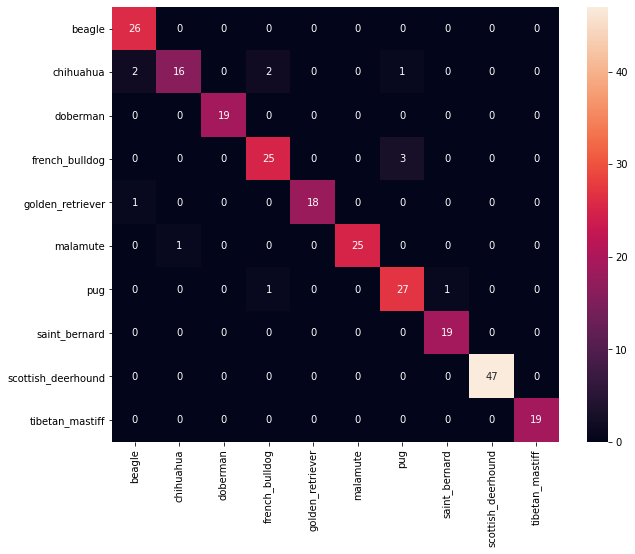

In [135]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
confusion_df = pd.DataFrame(matrix, index = dogs, columns = dogs)
plt.figure(figsize = (10,8))
sn.heatmap(confusion_df, annot=True)

In [ ]:
# Saving our model for future use:

model.save('dog_breed_model.h5')  

**Conclusion**: Our model performs well on the given data with overall accuracy of 0.95


# 6 Testing on custom image data



In [238]:
def breed_predictor(image_file):
    image = cv2.imread(image_file)
    image = cv2.resize(image, (300, 300))
    # dog_img = Image.open(image_file)
    image = image.reshape(1,300,300,3)
    result_prob = model.predict(image)
    result = result_prob.argmax(axis=-1)
    result = label_encoder.inverse_transform(result)
    return f'Predicted Breed: {result[0]} with probability of {round(np.amax(result_prob)*100,2)}%'

In [239]:
file_n = 'gold_ret.jpg'
breed_predictor(file_n)


'Predicted Breed: golden_retriever with probability of 99.83%'

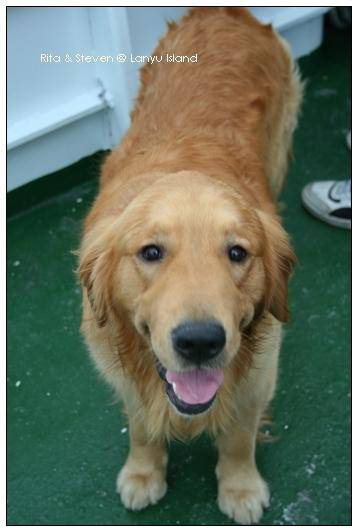

In [219]:
Image.open(file_n)

In [243]:
file_n = 'dobber.jpg'
breed_predictor(file_n)

'Predicted Breed: doberman with probability of 100.0%'

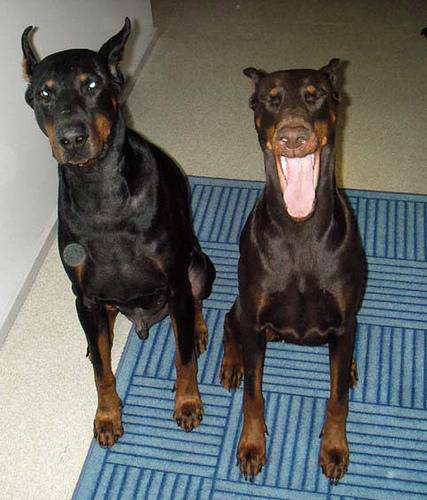

In [244]:
Image.open(file_n)

In [241]:
file_n = 'saint_berni.jpg'
breed_predictor(file_n)

'Predicted Breed: saint_bernard with probability of 99.62%'

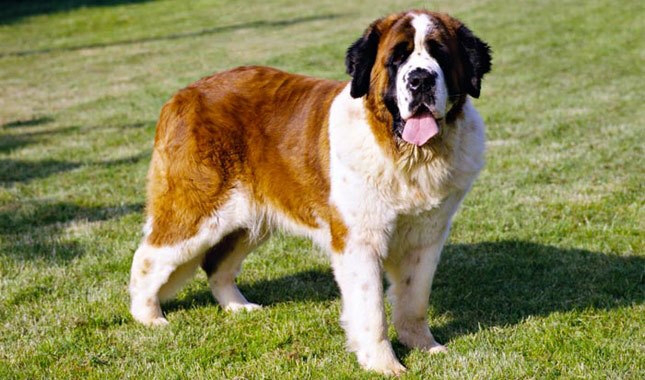

In [242]:
Image.open(file_n)